In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from sklearn.cluster import KMeans
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import tensorflow as tf

import ucl_v1_FC

import utilities # this file must be in the same folder as the notebook

import seaborn as sns
import umap
import umap.plot

In [2]:
from importlib import reload
reload(ucl_v1_FC)
ucl_v1_FC.create_model

<function ucl_v1_FC.create_model(core_model, weights, input_shape, core_output_layer=None, n_clusters=2, learning_rate=0.0001, momentum=0.9, random_seed=None)>

In [3]:
tf.keras.backend.clear_session
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [9]:
# Constants used for learning
WORK_IMG_SIZE = 112,112 # Note: (224, 224) is default for most pretrained models
INPUT_SHAPE = WORK_IMG_SIZE + (3,) # 3 for rgb, since model is pretrained for color images
BATCH_SIZE = 1024

# dt = datetime.now()
# timestamp = str(dt)[:str(dt).find(".")].replace("-", "").replace(":", "").replace(" ", "_")  # use for log file name

STORE_Path = "Results_v2/Res_F1"
CHECKPOINTS_Path = STORE_Path+"/checkpoints/"
LOGS_Path = STORE_Path+"/"
PLOTS_Path = STORE_Path+"/plots/"

# create directories
os.makedirs(CHECKPOINTS_Path)
os.makedirs(PLOTS_Path)

FileExistsError: [Errno 17] File exists: 'Results_v2/Res_F1/checkpoints/'

In [10]:
# Data Generator for feature extraction (only standardization, no randomness)
ext_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True #False
                                        )

# This one is for the training (contains randomized augmentations)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                            samplewise_center=True, #False,
                                            samplewise_std_normalization=True, #False,
                                            rotation_range=30, # 0,
                                            brightness_range=None, # ?
                                            shear_range=0.1, # 0.0,
                                            zoom_range=0.1, # 0.0,
                                            channel_shift_range=0.0,
                                            fill_mode='nearest',
                                            cval=0.0,
                                            horizontal_flip=True, # False,
                                            vertical_flip=True, # False,
                                        )

In [11]:
train_paths_df = utilities.make_path_df(["grs_nogrs_Training.txt"])
valid_paths_df = utilities.make_path_df(["grs_nogrs_Validate.txt"])
test_paths_df = utilities.make_path_df(["grs_nogrs_Test.txt"])

train_paths_df = train_paths_df.append(valid_paths_df, ignore_index=True)

# Replace labels with integers. Keep names for future use.
label_names = train_paths_df["label"].unique()
label_dict = {}
for e,l in enumerate(label_names): label_dict[l] = e
train_paths_df["label"].replace(label_dict, inplace=True) 
test_paths_df["label"].replace(label_dict, inplace=True) 

# Checks...
if len(train_paths_df[train_paths_df.duplicated()]) > 0: #should not happen...
    print("WARNING, there are duplicates in the dataset.")
    #print(paths_df[paths_df.duplicated()])
    
print(f"Training data: {len(train_paths_df)}\nTesting data: {len(test_paths_df)}")
print("Unique labels: ",label_names, len(label_names))
print(train_paths_df["label"].value_counts())
print(test_paths_df["label"].value_counts())

Training data: 53568
Testing data: 13378
Unique labels:  ['grass' 'not_grass'] 2
0    42048
1    11520
Name: label, dtype: int64
0    8435
1    4943
Name: label, dtype: int64


In [12]:
test_paths_df

,path,label
0,../Dataset/data/Test/Ferny/CLASS_1_Image_91_Ce...,0
1,../Dataset/data/Test/Ferny/CLASS_1_Image_105_C...,0
2,../Dataset/data/Test/Ferny/CLASS_1_Image_134_C...,0
3,../Dataset/data/Test/Ferny/CLASS_1_Image_118_C...,0
4,../Dataset/data/Test/Ferny/CLASS_1_Image_198_C...,0
...,...,...
13373,../Dataset/data/Test/Background/CLASS_3_Image_...,1
13374,../Dataset/data/Test/Background/CLASS_3_Image_...,1
13375,../Dataset/data/Test/Background/CLASS_3_Image_...,1
13376,../Dataset/data/Test/Background/CLASS_3_Image_...,1


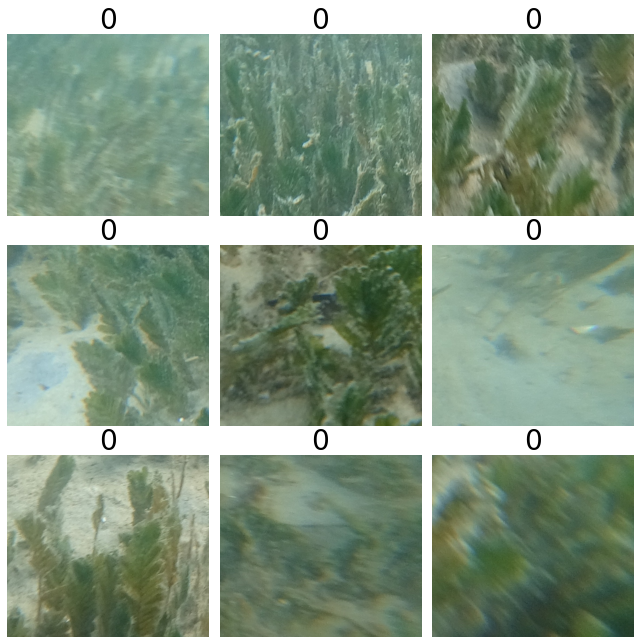

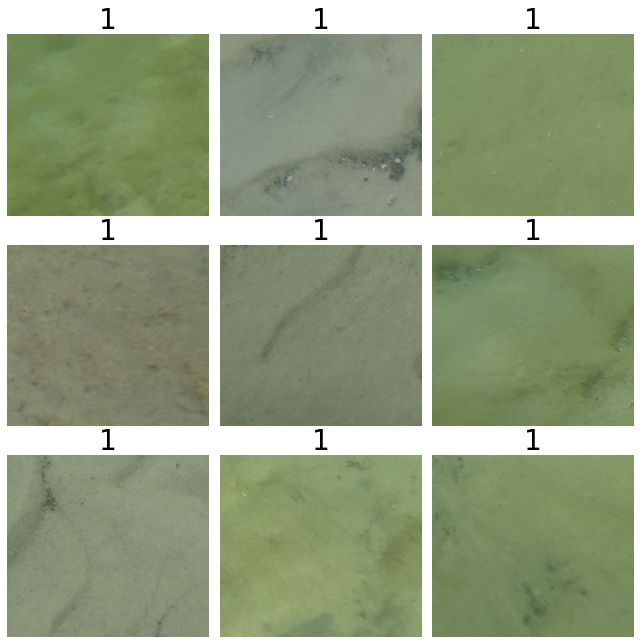

In [13]:
towerimgs = utilities.view_images(train_paths_df[train_paths_df["label"]==0],
                                  #y_train[y_train==0],
                                  n_images=9,
                                  cmap="Greys",
                                  #randomize=True,
                                  size=(3,3)).tight_layout()
notowerimgs = utilities.view_images(train_paths_df[train_paths_df["label"]==1],
                                    #y_train[y_train==1],
                                    n_images=9,
                                    cmap="Greys",
                                    #randomize=True,
                                    size=(3,3)).tight_layout()

## UMAP

In [19]:
initial_model = tf.keras.models.load_model(CHECKPOINTS_Path+"26.ckpt")

features = ucl_v1_FC.extract_features(test_paths_df["path"], model=initial_model, img_datagen=ext_datagen,
                                    batch_size=BATCH_SIZE, img_size=WORK_IMG_SIZE,
                                    random_seed=101)

Found 13378 validated image filenames.
Extracting features from data...done! Features extracted. Shape: (13378, 4608)


In [20]:
standard_embedding = umap.UMAP(random_state=42).fit(features)

<AxesSubplot:>

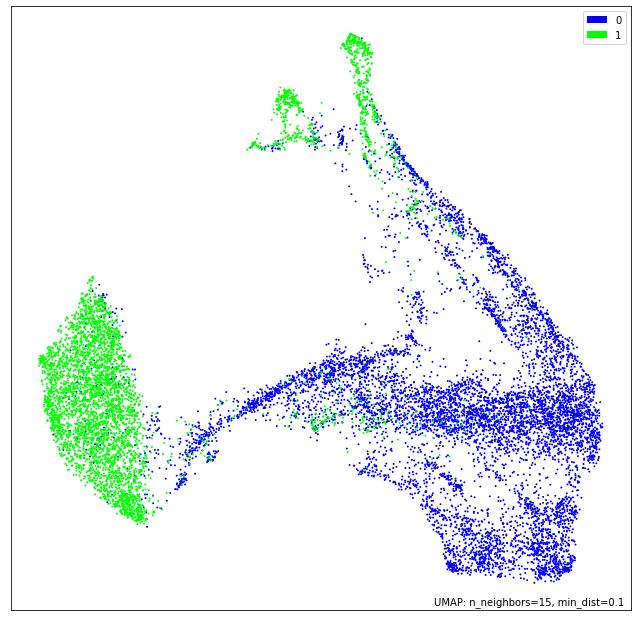

In [21]:

umap.plot.points(standard_embedding, color_key_cmap='brg',labels=test_paths_df["label"])

Clustering features into 2 clusters...using random clustering...done!


<AxesSubplot:>

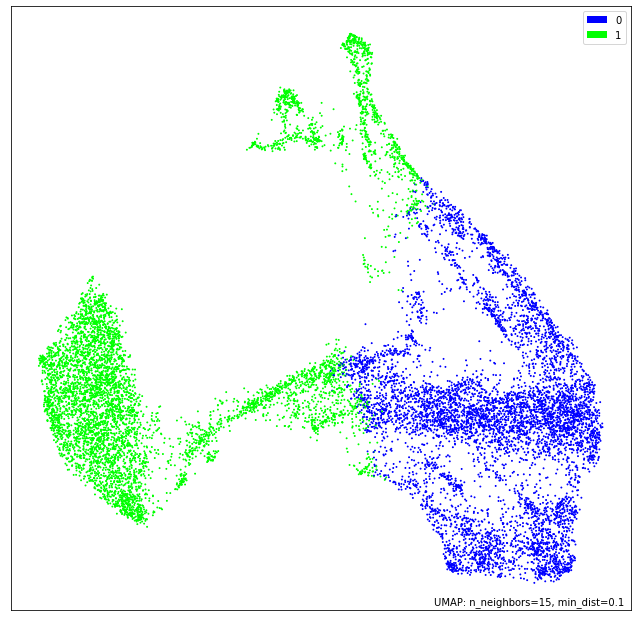

In [22]:
clust = ucl_v1_FC.make_clusters(features,
                  n_clusters=2,
                  centroids=None,
                  random_seed=None)
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=clust.labels_)

Found 13378 validated image filenames belonging to 1 classes.
[(0, 1), (1, 0)]


<AxesSubplot:>

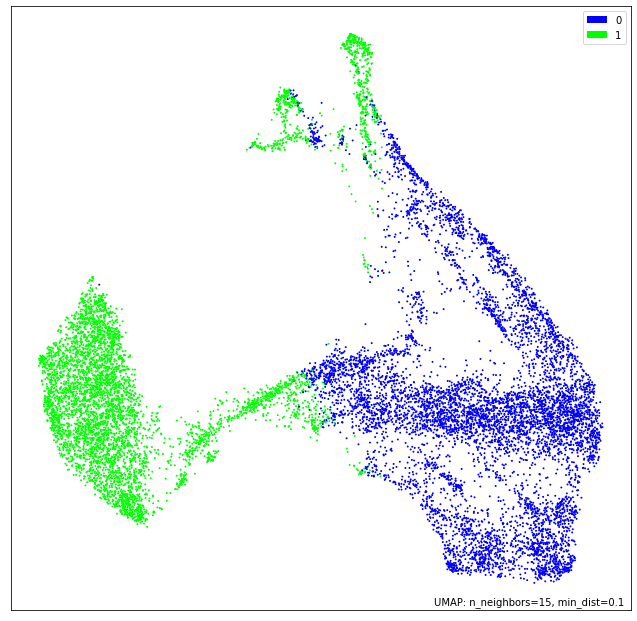

In [25]:
preds_df = ucl_v1_FC.predict_model(initial_model,test_paths_df["path"], labels=test_paths_df["label"], ext_datagen=ext_datagen, random_seed=101)
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=preds_df["p_pred"])

In [23]:
from sklearn.cluster import DBSCAN
hdb =  DBSCAN(eps=10, min_samples=20) #eps=20, min_samples=20 when we saw a few samples with green class
clust = hdb.fit(features)

<AxesSubplot:>

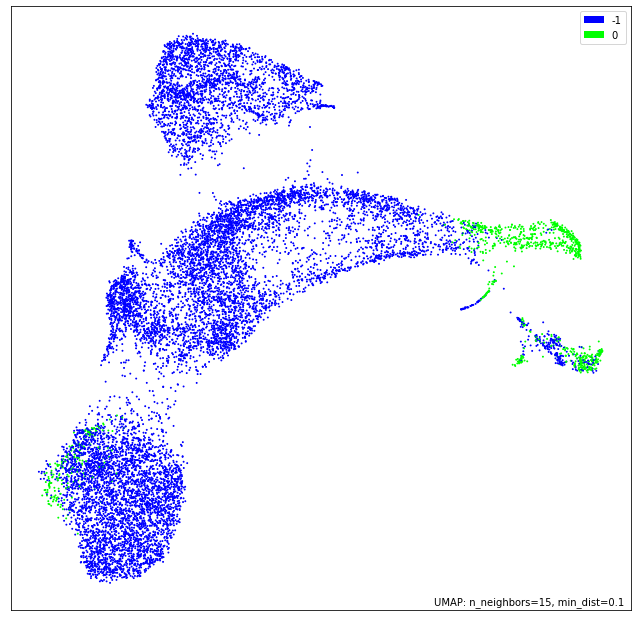

In [58]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=clust.labels_)

In [36]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=2).fit(features)

<AxesSubplot:>

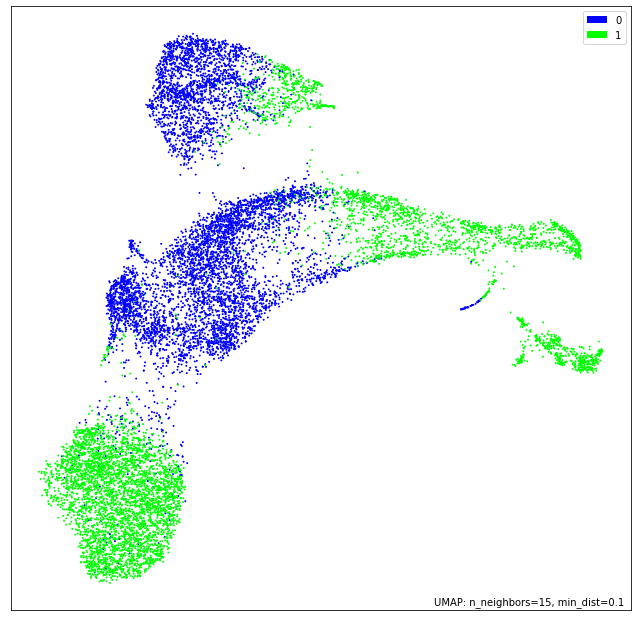

In [38]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=1-clustering.labels_)

In [45]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(features)

In [51]:
labels = gm.predict(features)

<AxesSubplot:>

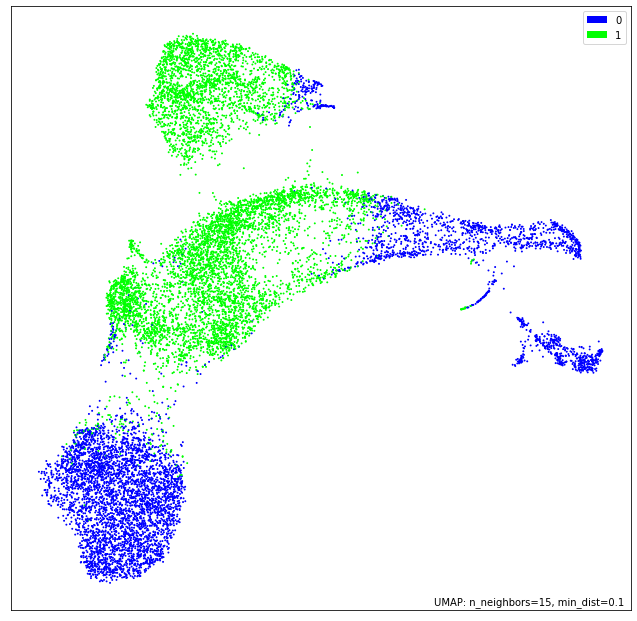

In [52]:
umap.plot.points(standard_embedding, color_key_cmap='brg',labels=labels)